In [1]:
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model

# Carpeta donde guardar
save_dir = "modelos"
os.makedirs(save_dir, exist_ok=True)

2025-11-26 11:02:33.876285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764154954.103614      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764154954.165940      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def create_transfer_model(base_model_fn, input_shape=(224,224,3), n_classes=1, dropout=0.2, trainable_layers=0):
    base = base_model_fn(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # Congelamos todas las capas primero
    base.trainable = False

    # Si se especifican capas entrenables, las activamos desde el final
    if trainable_layers > 0:
        for layer in base.layers[-trainable_layers:]:
            layer.trainable = True

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    output = Dense(n_classes, activation="sigmoid")(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model


def train_model(model, train_gen, val_gen, epochs=20, class_weights=None):
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4)
    ]
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=callbacks
    )
    return history

def evaluate_model(model, generator, name="Model"):
    y_true = generator.classes
    y_pred = (model.predict(generator) > 0.5).astype("int32").ravel()

    print(f"\nResultados para {name}")
    print(classification_report(y_true, y_pred, target_names=list(generator.class_indices.keys())))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=generator.class_indices.keys(),
                yticklabels=generator.class_indices.keys())
    plt.title(f"Matriz de confusión - {name}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    return cm

# Cargamos Datos

In [3]:
data_dir = "/kaggle/input/hampreprocessed/processed/train"
val_dir = "/kaggle/input/hampreprocessed/processed/val"

def get_generators(data_dir, preprocess_fn, target_size=(224, 224), batch_size=256):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        shear_range=0.2,
        horizontal_flip=True
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    val_generator = ImageDataGenerator(preprocessing_function=preprocess_fn).flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, val_generator

train_generator, val_generator = get_generators(data_dir, lambda x: x)
print(pd.Series(val_generator.classes).value_counts())
print(pd.Series(train_generator.classes).value_counts())

labels = train_generator.classes  

# Calculamos los pesos
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

# Lo convertimos en diccionario para Keras
class_weights = dict(enumerate(class_weights))
print(class_weights)

Found 8517 images belonging to 2 classes.
Found 496 images belonging to 2 classes.
0    399
1     97
Name: count, dtype: int64
0    6855
1    1662
Name: count, dtype: int64
{0: 0.6212253829321663, 1: 2.562274368231047}


# Entrenamiento de modelos con Transfer Learning

## VGG

In [4]:
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
train_generator, val_generator = get_generators(data_dir, vgg16_preprocess)

Found 8517 images belonging to 2 classes.
Found 496 images belonging to 2 classes.


In [5]:
vgg_model = create_transfer_model(VGG16, trainable_layers= 0)
train_model(vgg_model, train_generator, val_generator, class_weights=class_weights, epochs=40)

I0000 00:00:1764061308.432202     445 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1764061324.547248     522 service.cc:148] XLA service 0x783a78010740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764061324.547288     522 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764061324.921861     522 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/34 ━━━━━━━━━━━━━━━━━━━━ 9:51 18s/step - accuracy: 0.7101 - loss: 2.0432

I0000 00:00:1764061338.292188     522 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-25 09:02:29.981673: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[256,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-25 09:02:30.688872: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.707309285s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[256,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,64,224

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6116 - loss: 1.1269

2025-11-25 09:06:07.538043: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[240,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[240,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-25 09:06:08.138752: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.600842019s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[240,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[240,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

34/34 ━━━━━━━━━━━━━━━━━━━━ 278s 8s/step - accuracy: 0.6100 - loss: 1.1210 - val_accuracy: 0.5786 - val_loss: 0.7089 - learning_rate: 1.0000e-04
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.5960 - loss: 0.7076 - val_accuracy: 0.6472 - val_loss: 0.6250 - learning_rate: 1.0000e-04
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.6525 - loss: 0.6199 - val_accuracy: 0.6633 - val_loss: 0.5826 - learning_rate: 1.0000e-04
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.6796 - loss: 0.5840 - val_accuracy: 0.6573 - val_loss: 0.5910 - learning_rate: 1.0000e-04
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 167s 5s/step - accuracy: 0.6946 - loss: 0.5427 - val_accuracy: 0.6734 - val_loss: 0.5746 - learning_rate: 1.0000e-04
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.6971 - loss: 0.5408 - val_accuracy: 0.6875 - val_loss: 0.5533 - learning_rate: 1.0000e-04
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.7059 - loss: 0.5

In [6]:
vgg_model_old_weights = vgg_model.get_weights()

vgg_model = create_transfer_model(VGG16, trainable_layers= 4)
vgg_model.set_weights(vgg_model_old_weights)
history_vgg = train_model(vgg_model, train_generator, val_generator, class_weights=class_weights)

# Guardar
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
vgg_model.save(os.path.join(save_dir, f"vgg16_finetuned_{timestamp}.keras"))

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - accuracy: 0.7176 - loss: 0.4945 - val_accuracy: 0.7964 - val_loss: 0.4173 - learning_rate: 1.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.7729 - loss: 0.3903 - val_accuracy: 0.7278 - val_loss: 0.5201 - learning_rate: 1.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.7876 - loss: 0.3721 - val_accuracy: 0.8165 - val_loss: 0.3789 - learning_rate: 1.0000e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 161s 5s/step - accuracy: 0.8160 - loss: 0.3402 - val_accuracy: 0.7480 - val_loss: 0.4670 - learning_rate: 1.0000e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - accuracy: 0.8376 - loss: 0.3210 - val_accuracy: 0.8468 - val_loss: 0.3894 - learning_rate: 1.0000e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.8508 - loss: 0.2975 - val_accuracy: 0.8266 - val_loss: 0.3830 - learning_rate: 1.0000e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.8577 

## ResNet

In [4]:
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
train_generator, val_generator = get_generators(data_dir, resnet_preprocess)

Found 8517 images belonging to 2 classes.
Found 496 images belonging to 2 classes.


In [5]:
resnet_model = create_transfer_model(ResNet50, trainable_layers= 0)
train_model(resnet_model, train_generator, val_generator, class_weights=class_weights, epochs=40)

I0000 00:00:1764155000.701073      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1764155046.796980     127 service.cc:148] XLA service 0x7d4c98002700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764155046.798054     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764155048.483743     127 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764155059.240258     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 293s 8s/step - accuracy: 0.6167 - loss: 0.6413 - precision: 0.3068 - recall: 0.6875 - val_accuracy: 0.7560 - val_loss: 0.4622 - val_precision: 0.4130 - val_recall: 0.5876 - learning_rate: 1.0000e-04
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - accuracy: 0.7652 - loss: 0.4607 - precision: 0.4504 - recall: 0.8106 - val_accuracy: 0.7379 - val_loss: 0.4809 - val_precision: 0.3988 - val_recall: 0.6701 - learning_rate: 1.0000e-04
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - accuracy: 0.7525 - loss: 0.4506 - precision: 0.4381 - recall: 0.8482 - val_accuracy: 0.7460 - val_loss: 0.4475 - val_precision: 0.4088 - val_recall: 0.6701 - learning_rate: 1.0000e-04
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - accuracy: 0.7709 - loss: 0.4311 - precision: 0.4559 - recall: 0.8340 - val_accuracy: 0.7440 - val_loss: 0.4390 - val_precision: 0.4074 - val_recall: 0.6804 - learning_rate: 1.0000e-04
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 

In [6]:
resnet_model_old_weights = resnet_model.get_weights()

resnet_model = create_transfer_model(ResNet50, trainable_layers= 4)
resnet_model.set_weights(resnet_model_old_weights)
history_resnet = train_model(resnet_model, train_generator, val_generator, class_weights=class_weights)

# Guardar
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
resnet_model.save(os.path.join(save_dir, f"resnet50_finetuned_{timestamp}.keras"))

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.7900 - loss: 0.3964 - precision_1: 0.4850 - recall_1: 0.8621 - val_accuracy: 0.7399 - val_loss: 0.4717 - val_precision_1: 0.4167 - val_recall_1: 0.8247 - learning_rate: 1.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.8026 - loss: 0.3716 - precision_1: 0.4973 - recall_1: 0.8588 - val_accuracy: 0.7560 - val_loss: 0.4449 - val_precision_1: 0.4302 - val_recall_1: 0.7629 - learning_rate: 1.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.8086 - loss: 0.3517 - precision_1: 0.5065 - recall_1: 0.9002 - val_accuracy: 0.7802 - val_loss: 0.4040 - val_precision_1: 0.4647 - val_recall_1: 0.8144 - learning_rate: 1.0000e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.8162 - loss: 0.3501 - precision_1: 0.5211 - recall_1: 0.8823 - val_accuracy: 0.7742 - val_loss: 0.4000 - val_precision_1: 0.4551 - val_recall_1: 0.7835 - learning_rate: 1.0000e-04
Epoch 5/20
34/34 ━━━

## Inception

In [7]:
from keras.applications.xception import preprocess_input as xception_preprocess
train_generator, val_generator = get_generators(data_dir, xception_preprocess)

Found 8517 images belonging to 2 classes.
Found 496 images belonging to 2 classes.


In [8]:
inception_model = create_transfer_model(InceptionV3, trainable_layers= 0) 
train_model(inception_model, train_generator, val_generator, class_weights=class_weights, epochs=40)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.5727 - loss: 0.6834 - precision_2: 0.2315 - recall_2: 0.5243 - val_accuracy: 0.7278 - val_loss: 0.5786 - val_precision_2: 0.3623 - val_recall_2: 0.5155 - learning_rate: 1.0000e-04
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.7049 - loss: 0.5775 - precision_2: 0.3661 - recall_2: 0.7211 - val_accuracy: 0.7702 - val_loss: 0.5104 - val_precision_2: 0.4320 - val_recall_2: 0.5567 - learning_rate: 1.0000e-04
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.7268 - loss: 0.5588 - precision_2: 0.3995 - recall_2: 0.7250 - val_accuracy: 0.7742 - val_loss: 0.5105 - val_precision_2: 0.4453 - val_recall_2: 0.6289 - learning_rate: 1.0000e-04
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - accuracy: 0.7422 - loss: 0.5207 - precision_2: 0.4129 - recall_2: 0.7430 - val_accuracy: 0.7157 - val_loss: 0.5433 - val_precision_2: 0.3764 - val_recall_2: 0.69

In [9]:
inception_model_old_weights = inception_model.get_weights()

inception_model = create_transfer_model(InceptionV3, trainable_layers= 4) 
inception_model.set_weights(inception_model_old_weights)
history_incep = train_model(inception_model, train_generator, val_generator, class_weights=class_weights)

# Guardar
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
inception_model.save(os.path.join(save_dir, f"inceptionv3_finetuned_{timestamp}.keras"))

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.7748 - loss: 0.4566 - precision_3: 0.4477 - recall_3: 0.7896 - val_accuracy: 0.7480 - val_loss: 0.4735 - val_precision_3: 0.4114 - val_recall_3: 0.6701 - learning_rate: 1.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.7739 - loss: 0.4677 - precision_3: 0.4538 - recall_3: 0.7887 - val_accuracy: 0.7560 - val_loss: 0.4813 - val_precision_3: 0.4241 - val_recall_3: 0.6907 - learning_rate: 1.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.7735 - loss: 0.4649 - precision_3: 0.4591 - recall_3: 0.7980 - val_accuracy: 0.7722 - val_loss: 0.4566 - val_precision_3: 0.4467 - val_recall_3: 0.6907 - learning_rate: 1.0000e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.7772 - loss: 0.4545 - precision_3: 0.4694 - recall_3: 0.8243 - val_accuracy: 0.7802 - val_loss: 0.4251 - val_precision_3: 0.4538 - val_recall_3: 0.6082 - learning_rate: 1.0000e-04
Epoch 5/20
34/34 ━━━

# Evaluación

In [20]:
test_generator = lambda x: ImageDataGenerator(preprocessing_function=x).flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=256,
        class_mode='binary',
        shuffle=False
    )

Found 496 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

2025-11-26 13:24:10.961913: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[240,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[240,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-26 13:24:11.561795: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.600003925s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[240,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[240,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 43s/step

Resultados para VGG16
              precision    recall  f1-score   support

    benignas       0.94      0.92      0.93       399
    malignas       0.70      0.76      0.73        97

    accuracy                           0.89       496
   macro avg       0.82      0.84      0.83       496
weighted avg       0.89      0.89      0.89       496



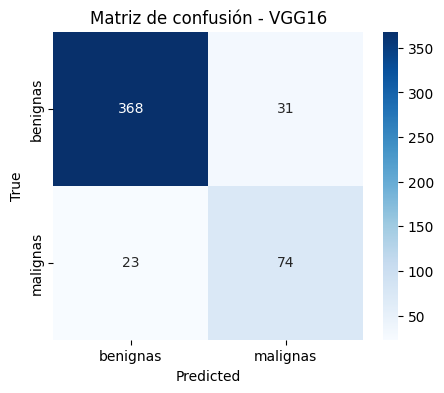

array([[368,  31],
       [ 23,  74]])

In [21]:
evaluate_model(vgg_model, test_generator(vgg16_preprocess), name="VGG16")

Found 496 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step

Resultados para Xception
              precision    recall  f1-score   support

    benignas       0.90      0.82      0.86       399
    malignas       0.45      0.61      0.52        97

    accuracy                           0.78       496
   macro avg       0.68      0.72      0.69       496
weighted avg       0.81      0.78      0.79       496



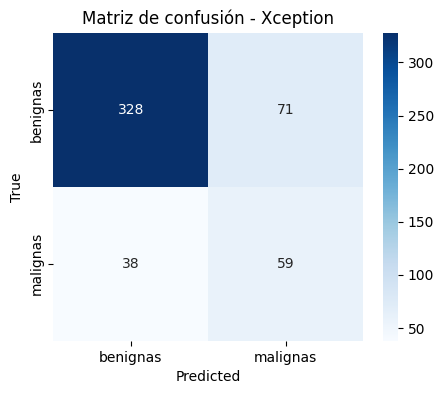

array([[328,  71],
       [ 38,  59]])

In [22]:
evaluate_model(inception_model, test_generator(xception_preprocess), name="Xception")


Found 496 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step

Resultados para ResNet50
              precision    recall  f1-score   support

    benignas       0.93      0.80      0.86       399
    malignas       0.48      0.76      0.59        97

    accuracy                           0.79       496
   macro avg       0.70      0.78      0.72       496
weighted avg       0.84      0.79      0.81       496



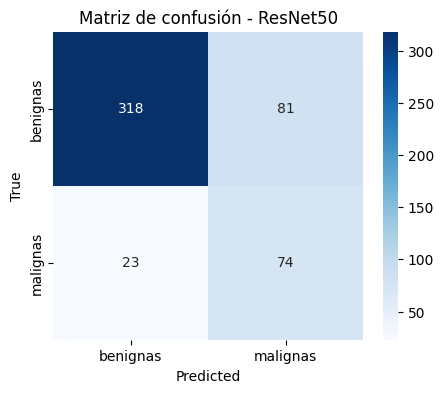

array([[318,  81],
       [ 23,  74]])

In [23]:
evaluate_model(resnet_model, test_generator(resnet_preprocess), name="ResNet50")